In [214]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 11 08:41:55 2024

@author: Manasa Kesapragada
"""

import pandas as pd
import numpy as np
import math
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers.legacy import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import pdb
from keras.regularizers import l2

Parameters

In [215]:
base = "/Users/alexandranava/Desktop/Spores/"
experiment1 = "M4576_s7" # 135
experiment2 = "M4581_s7" # 107 

df_train = pd.read_csv(f"/Users/alexandranava/Desktop/Spores/M4576_s7/PostProcess_V2/M4576_s7_Model_Data_V2.csv")
df_test = pd.read_csv(f"/Users/alexandranava/Desktop/Spores/M4581_s7/PostProcess_V4/M4581_s7_Model_Data_V2.csv")

In [216]:
df_test = pd.read_csv("/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data_V2.csv")
df_train = pd.read_csv("/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data_V2.csv")

Initialize Data

In [217]:
print(df_train.columns)
columns_to_drop = ['X_POSITION', 'Y_POSITION', 'ELLIPSE_MAJOR']
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)
#df['drug'] = df['drug'].fillna(0)

# Reset particle IDs to start from 1
df_train['new_spore_id'], unique_ids = pd.factorize(df_train['SPORE_ID'])
df_train['new_spore_id'] = df_train['new_spore_id'] + 1

df_test['new_spore_id'], unique_ids = pd.factorize(df_test['SPORE_ID'])
df_test['new_spore_id'] = df_test['new_spore_id'] + 1

# Drop index columns
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

#plt.hist(df_train['PERIMETER'])
input_cols = ['INTENSITY','AREA','GERMINANT_EXPOSURE','ELLIPSE_MINOR', 'ELLIPSE ASPECT RATIO' , 'GERMINATION']
output_cols = 'GERMINATION'

Index(['Unnamed: 0', 'SPORE_ID', 'FRAME', 'X_POSITION', 'Y_POSITION',
       'GERMINATION', 'INTENSITY', 'AREA', 'GERMINANT_EXPOSURE',
       'ELLIPSE_MINOR', 'ELLIPSE_MAJOR', 'PERIMETER', 'CIRCULARITY',
       'ELLIPSE ASPECT RATIO'],
      dtype='object')


In [218]:
def create_dataset(df, cells, lookback=3, in_cols= input_cols, out_cols=output_cols, drug_conc=[1]):
    trainX, trainY = [], [] #lists of training and testing inputs/outputs
    for drug in drug_conc:
        for track in range(cells[0], cells[1]):
            cell = df.loc[(df["new_spore_id"] == track)] #all rows of data pertaining to this cell
            cell = cell[in_cols] #reduce it to our columns of interest
            for i in range(len(cell)-lookback-1):
                trainX.append(cell[i:i+lookback])
            cell = cell[out_cols]
            #pdb.set_trace()
            for i in range(len(cell)-lookback-1):
                trainY.append(cell[i+lookback+1:i+lookback+2])

    trainX = np.array(list(map(lambda x: x.to_numpy(), trainX)))
    trainY = np.array(list(map(lambda x: x.to_numpy(), trainY)))
    return np.array(trainX), np.array(trainY)


# calculate data for train with 80% val with 20%
num_train_data = len(list(df_train["SPORE_ID"].unique()))
train_len = int(num_train_data * 0.85)
num_test_data = len(df_test["SPORE_ID"].unique())
print(f"training on spores (1, {train_len})...")
print(f"validating on spores ({train_len + 1}, {num_train_data})...")
print(f"testing on spores ({1, num_test_data})")

#training
trainX, trainY = create_dataset(df_train,cells=(1, train_len))
valX, valY = create_dataset(df_train, cells=(train_len + 1, num_train_data))
#testing
testX, testY = create_dataset(df_test, cells=(1, num_test_data))


training on spores (1, 64)...
validating on spores (65, 76)...
testing on spores ((1, 54))


Training model number 0
Epoch 1/30
17136/17136 [==============================] - 21s 1ms/step - loss: 0.2255 - accuracy: 0.9635 - val_loss: 0.0360 - val_accuracy: 0.9926
Epoch 2/30
17136/17136 [==============================] - 18s 1ms/step - loss: 0.1637 - accuracy: 0.9826 - val_loss: 0.0355 - val_accuracy: 0.9926
Epoch 3/30
17136/17136 [==============================] - 17s 1ms/step - loss: 0.1723 - accuracy: 0.9822 - val_loss: 0.0341 - val_accuracy: 0.9926
Epoch 4/30
17136/17136 [==============================] - 17s 994us/step - loss: 0.3333 - accuracy: 0.9721 - val_loss: 0.0380 - val_accuracy: 0.9926
Epoch 5/30
17136/17136 [==============================] - 17s 992us/step - loss: 0.8351 - accuracy: 0.9416 - val_loss: 0.0335 - val_accuracy: 0.9926
Epoch 6/30
17136/17136 [==============================] - 17s 1ms/step - loss: 0.1687 - accuracy: 0.9833 - val_loss: 0.0382 - val_accuracy: 0.9926
Epoch 7/30
17136/17136 [==============================] - 17s 1ms/step - loss: 0.1477 - ac

/Users/alexandranava/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


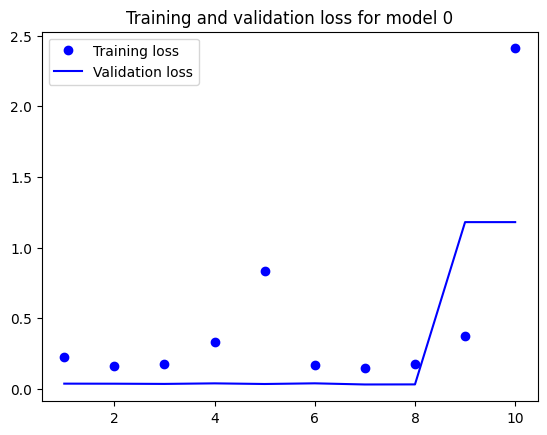

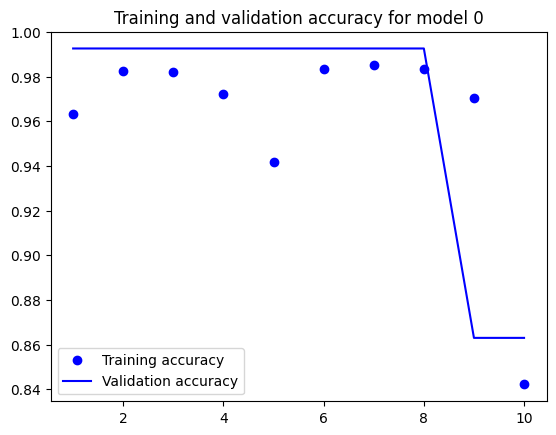

473/473 [==============================] - 0s 611us/step
Training RMSE: 0.08574929257125442
Validation RMSE: 0.08574929257125442
Testing RMSE: 0.08377078165833911
Model number: 0, distance from mean: 0.0
Returning model 0, whose distance is 0.0


In [219]:
#trains numerous models using a list of numbers to initialize the models
def typical_model(trainX,trainY,valX,valY,testX,testY,numbers):
    models = [] #list of models
    predictions = [] #list of prediction vectors

    for i in numbers:
        
        # MODEL TRAINING
        print('Training model number {}'.format(i))
        model = Sequential()
        model.add(LSTM(80, input_shape=(trainX.shape[1], trainX.shape[2]))) #(Lookback of 1)
        model.add(Dense(1, activation='sigmoid'))
        model.add(Dropout(0.01))
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=30, batch_size=1, verbose=1, callbacks=[early_stopping])
        models.append(model)
        model.summary()

        model.save("initial_{}.h5".format(i))
        print("Saved model {} to disk".format(i))
        
        # PLOT TRAINING AND VALIDATION LOSS
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss for model {}'.format(i))
        plt.legend()
        plt.show()
        
        # PLOT TRAINING AND VALIDATION ACCURACY
        loss = history.history['accuracy']
        val_loss = history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training accuracy')
        plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy for model {}'.format(i))
        plt.legend()
        plt.show()

        #Predict on training, validation, and test sets
        trainPredict = model.predict(trainX)
        valPredict = model.predict(valX)
        testPredict = model.predict(testX)

        # Threshold the predictions to get binary outputs
        trainPredict_binary = (trainPredict > 0.5).astype(int)
        valPredict_binary = (valPredict > 0.5).astype(int)
        testPredict_binary = (testPredict > 0.5).astype(int)

        # Calculate RMSEs
        trainScore = math.sqrt(mean_squared_error(trainY, trainPredict_binary))
        print('Training RMSE: {}'.format(trainScore))
        valScore = math.sqrt(mean_squared_error(valY, valPredict_binary))
        print('Validation RMSE: {}'.format(valScore))
        testScore = math.sqrt(mean_squared_error(testY, testPredict_binary))
        print('Testing RMSE: {}'.format(testScore))

        # add predictions to list of prediction vectors
        preds = np.concatenate([trainPredict_binary, valPredict_binary, testPredict_binary], axis=None)
        predictions.append(preds)


    #find the average of all prediction vectors
    mean_pred = np.mean(predictions,axis=0)

    #find the prediction vector that is closest to the mean
    closest = 0 #index of the prediction vector that is closest to the mean
    dist = 100 #the distance of that closest vector to the mean vector
    for i in range(len(predictions)):
        thisdist = math.sqrt(mean_squared_error(predictions[i], mean_pred))

        print('Model number: {}, distance from mean: {}'.format(i,thisdist))

        if thisdist < dist:
            dist = thisdist
            closest = i

    #return the "most average" model
    print('Returning model {}, whose distance is {}'.format(closest,dist))
    return models, closest


models, closest = typical_model(trainX,trainY,valX,valY,testX,testY,range(1))
model = models[closest]
#model.save("alex_data_model_lk2.h5")
#model.save("alex_data_model_lk2.keras")
#print("Saved model to disk")


In [220]:
#Predict on training, validation, and test sets
trainPredict = model.predict(trainX)
trainPredict =(trainPredict > 0.5).astype(int)

valPredict = model.predict(valX)
valPredict =(valPredict > 0.5).astype(int)

testPredict = model.predict(testX)
testPredict =(testPredict > 0.5).astype(int)

473/473 [==============================] - 0s 570us/step


$ \text{True Positive Rate} = \frac{\text{TP}}{\text{TP} + \text{FN}} $

$ \text{False Positive Rate} = \frac{\text{FP}}{\text{FP} + \text{TN}} $



$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $

$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $

$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $

$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $


In [221]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1-score
train_accuracy = accuracy_score(trainY, trainPredict)
val_accuracy = accuracy_score(valY, valPredict)
test_accuracy = accuracy_score(testY, testPredict)
print("--------------------")
print("Accuracy:")
print('Training Accuracy: {}'.format(train_accuracy))
print('Validation Accuracy: {}'.format(val_accuracy))
print('Testing Accuracy: {}'.format(test_accuracy))

train_precision = precision_score(trainY, trainPredict)
val_precision = precision_score(valY, valPredict)
test_precision = precision_score(testY, testPredict)
print("--------------------")
print("Precision:")
print('Training Precision: {}'.format(train_precision))
print('Validation Precision: {}'.format(val_precision))
print('Testing Precision: {}'.format(test_precision))

train_recall = recall_score(trainY, trainPredict)
val_recall = recall_score(valY, valPredict)
test_recall = recall_score(testY, testPredict)
print("--------------------")
print("Recall:")
print('Training Recall: {}'.format(train_recall))
print('Validation Recall: {}'.format(val_recall))
print('Testing Recall: {}'.format(test_recall))

train_f1 = f1_score(trainY, trainPredict)
val_f1 = f1_score(valY, valPredict)
test_f1 = f1_score(testY, testPredict)
print("--------------------")
print("F1-Score:")
print('Training F1-Score: {}'.format(train_f1))
print('Validation F1-Score: {}'.format(val_f1))
print('Testing F1-Score: {}'.format(test_f1))

--------------------
Accuracy:
Training Accuracy: 0.9926470588235294
Validation Accuracy: 0.9926470588235294
Testing Accuracy: 0.9929824561403509
--------------------
Precision:
Training Precision: 1.0
Validation Precision: 1.0
Testing Precision: 1.0


--------------------
Recall:
Training Recall: 0.9913384202928439
Validation Recall: 0.9914794732765299
Testing Recall: 0.9916265107828423
--------------------
F1-Score:
Training F1-Score: 0.9956503728251864
Validation F1-Score: 0.9957215091404122
Testing F1-Score: 0.9957956528637157


In [222]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Plot ROC curve
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


Training AUC: 0.995669210146422


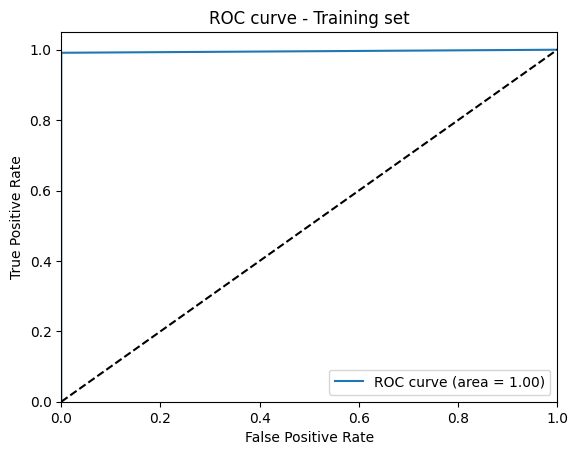

In [223]:
# Training set
train_auc = roc_auc_score(trainY, trainPredict)
print('Training AUC: {}'.format(train_auc))
plot_roc_curve(trainY, trainPredict, 'ROC curve - Training set')

Validation AUC: 0.995739736638265


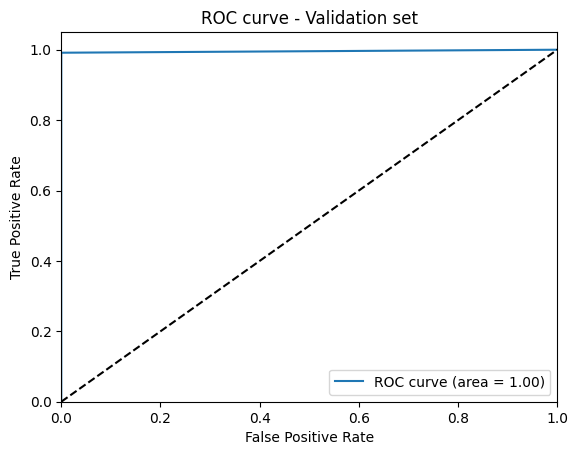

In [224]:
# Validation set
val_auc = roc_auc_score(valY, valPredict)
print('Validation AUC: {}'.format(val_auc))
plot_roc_curve(valY, valPredict, 'ROC curve - Validation set')

Testing AUC: 0.9958132553914212


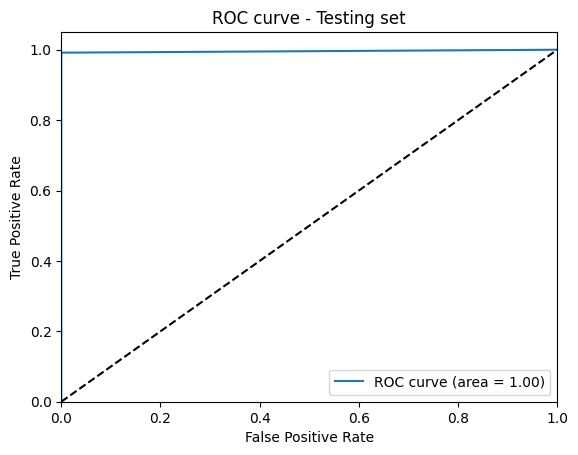

In [225]:
# Test set
test_auc = roc_auc_score(testY, testPredict)
print('Testing AUC: {}'.format(test_auc))
plot_roc_curve(testY, testPredict, 'ROC curve - Testing set')

               Predicted
             |   0   |   1   |
    --------------------------
    True  0  |  TN   |  FP   |
    True  1  |  FN   |  TP   |


In [226]:
# Confusion matrices
train_cm = confusion_matrix(trainY, trainPredict)
val_cm = confusion_matrix(valY, valPredict)
test_cm = confusion_matrix(testY, testPredict)
print('Training Confusion Matrix:')
print(train_cm)
print('Validation Confusion Matrix:')
print(val_cm)
print('Testing Confusion Matrix:')
print(test_cm)

Training Confusion Matrix:
[[ 2589     0]
 [  126 14421]]
Validation Confusion Matrix:
[[ 410    0]
 [  22 2560]]
Testing Confusion Matrix:
[[ 2446     0]
 [  106 12553]]


In [227]:
print('Writing results for model {}'.format(1))
maxtrack = int(max(df_test['new_spore_id']))
for track in range(1, maxtrack+1):
    print(f"track {track} of {maxtrack}...")
    cell = df_test.loc[(df_test['new_spore_id']==track)]
    if len(cell)==0:
        continue
    maxslice = max(df_test.loc[(df_test['new_spore_id']==track), 'FRAME'])+1
    minslice = min(df_test.loc[(df_test['new_spore_id']==track), 'FRAME'])
    for sl in range(int(minslice),int(maxslice+1)):
        x = cell.loc[(cell['FRAME']>sl-1) & (cell['FRAME']<=sl)]
        x = x[input_cols].to_numpy()
        if x.size > 0:
          x=x.reshape(1, 1, len(input_cols))
          df_test.loc[(df_test['new_spore_id']==track) & (df_test['FRAME']==sl), 'pred_germ{}'.format(1)] = model.predict(x)
 
df_test['pred_error{}'.format(1)] = df_test['pred_germ{}'.format(1)] - df_test['GERMINATION']
df_test['pred_germ1'] =(df_test['pred_germ1'] > 0.5).astype(int)


Writing results for model 1
track 1 of 54...
1/1 [==============================] - 0s 9ms/step
track 2 of 54...
1/1 [==============================] - 0s 11ms/step
track 3 of 54...
1/1 [==============================] - 0s 10ms/step
track 4 of 54...
1/1 [==============================] - 0s 10ms/step
track 5 of 54...
1/1 [==============================] - 0s 10ms/step
track 6 of 54...
1/1 [==============================] - 0s 10ms/step
track 7 of 54...
1/1 [==============================] - 0s 9ms/step
track 8 of 54...
1/1 [==============================] - 0s 10ms/step
track 9 of 54...
1/1 [==============================] - 0s 10ms/step
track 10 of 54...
1/1 [==============================] - 0s 9ms/step
track 11 of 54...
1/1 [==============================] - 0s 12ms/step
track 12 of 54...
1/1 [==============================] - 0s 10ms/step
track 13 of 54...
1/1 [==============================] - 0s 13ms/step
track 14 of 54...
1/1 [==============================] - 0s 14ms/step
trac

Plot of Predicted Spores Germinated against Actual Values

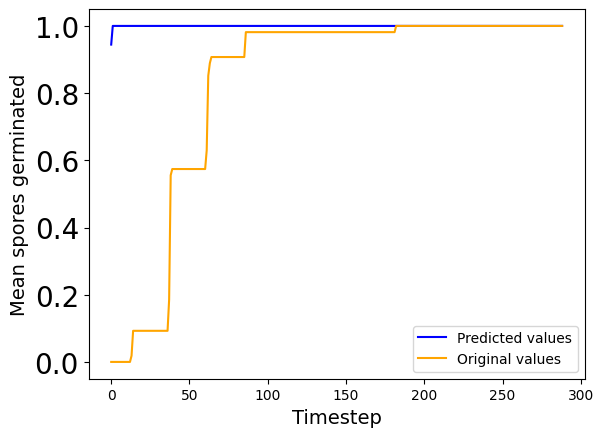

In [228]:
plt.errorbar(df_test['FRAME'].unique(),df_test.groupby(['FRAME']).mean()['pred_germ1'],
            color = 'b', label = 'Predicted values')
plt.errorbar(df_test['FRAME'].unique(),df_test.groupby(['FRAME']).mean()['GERMINATION'],
             color = 'orange', label = 'Original values')
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Mean spores germinated',fontsize=14)
plt.legend()

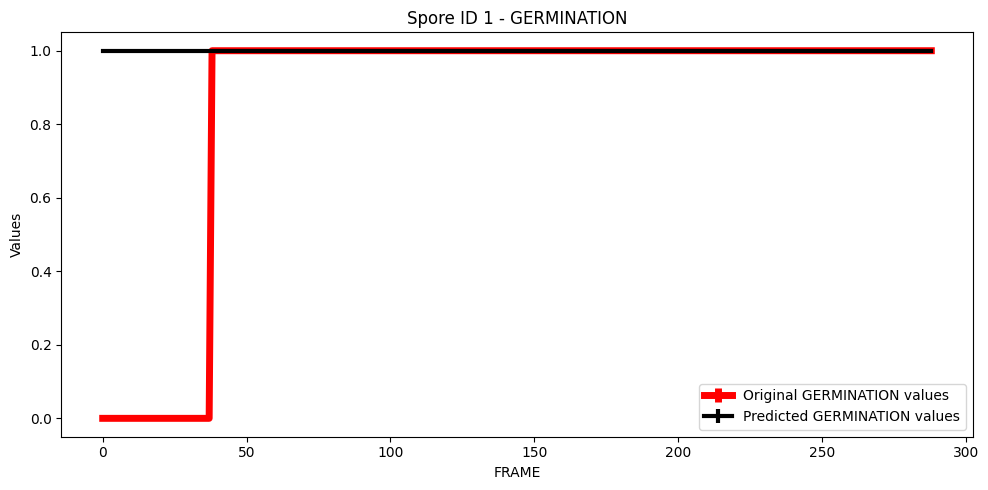

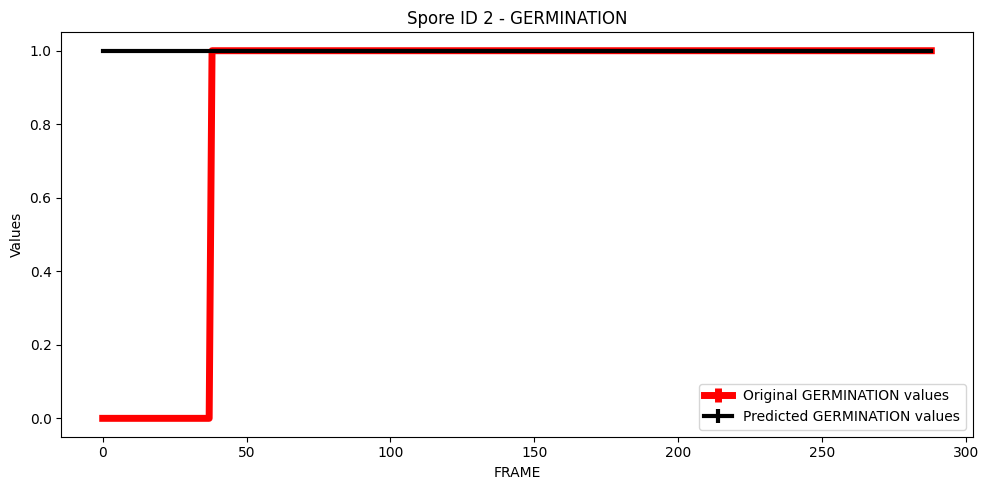

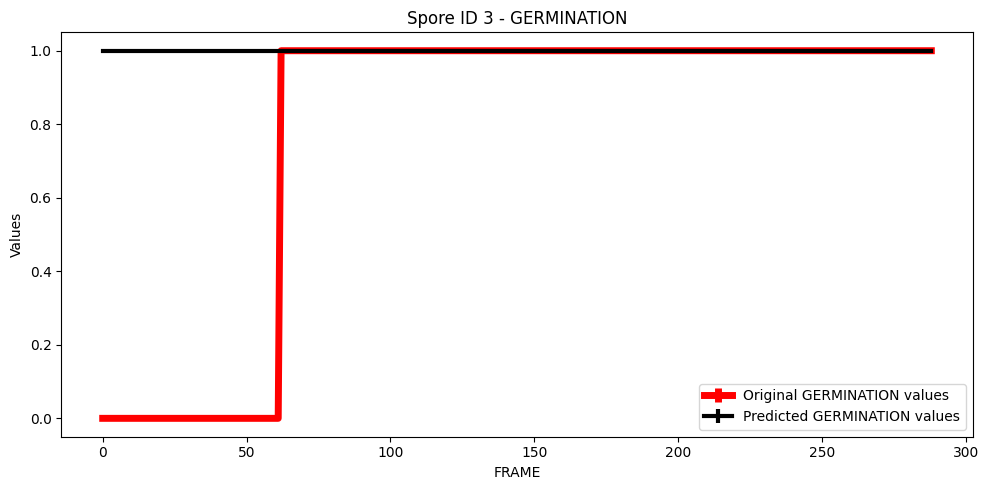

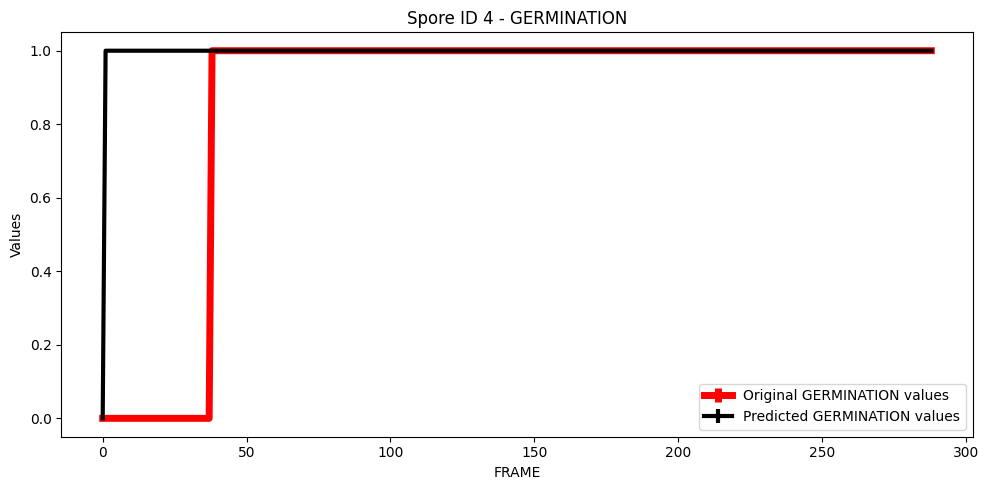

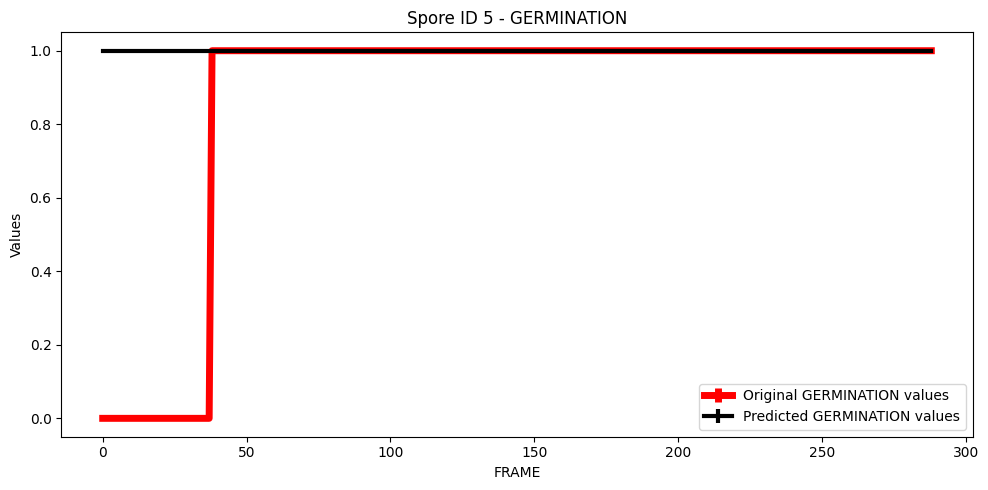

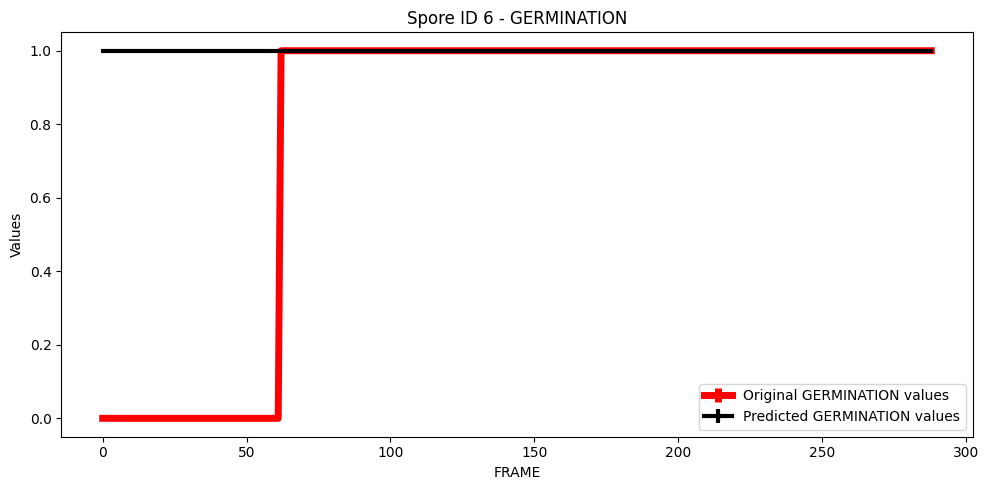

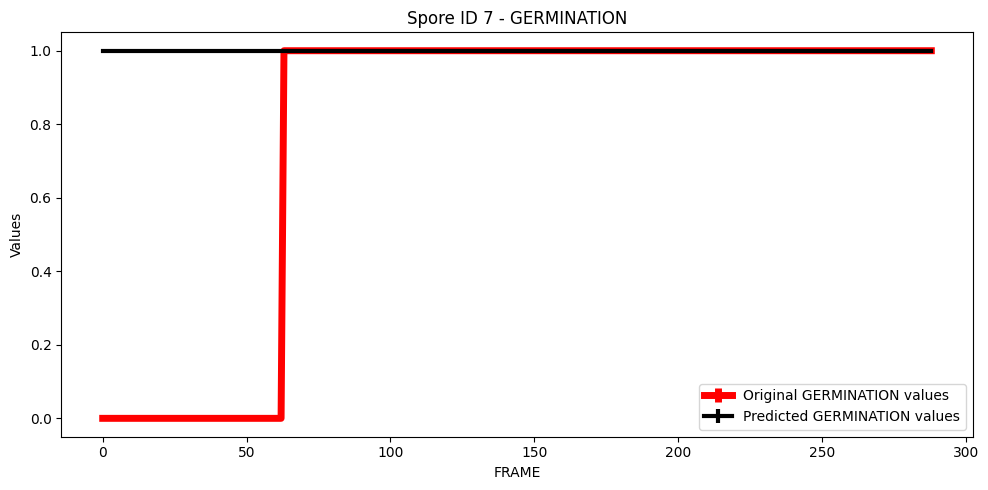

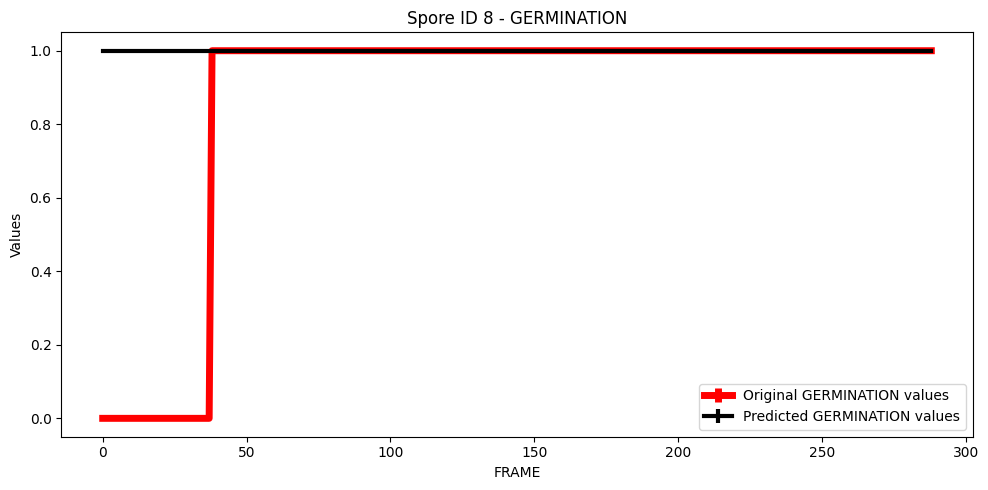

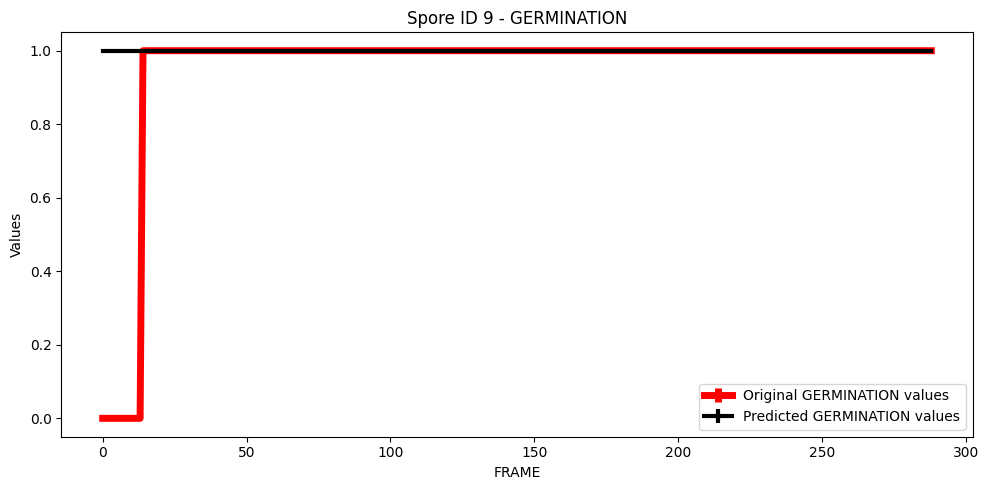

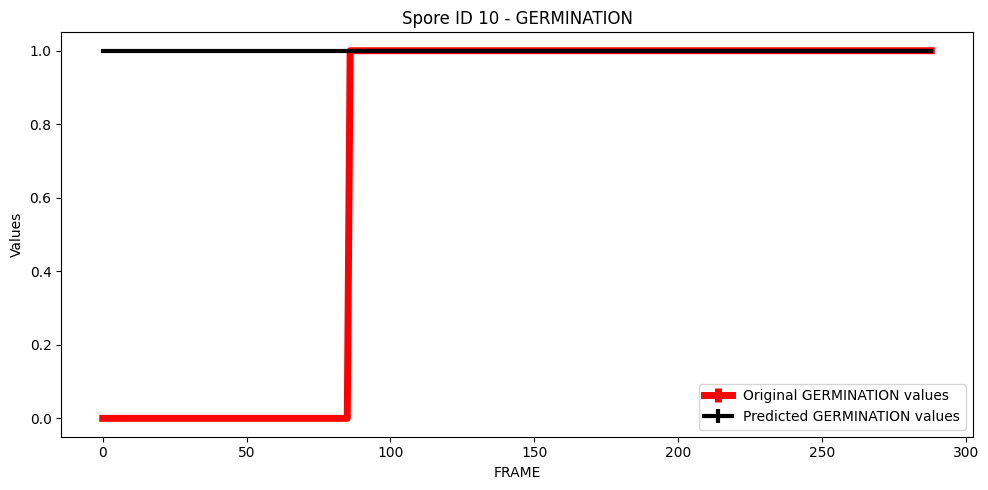

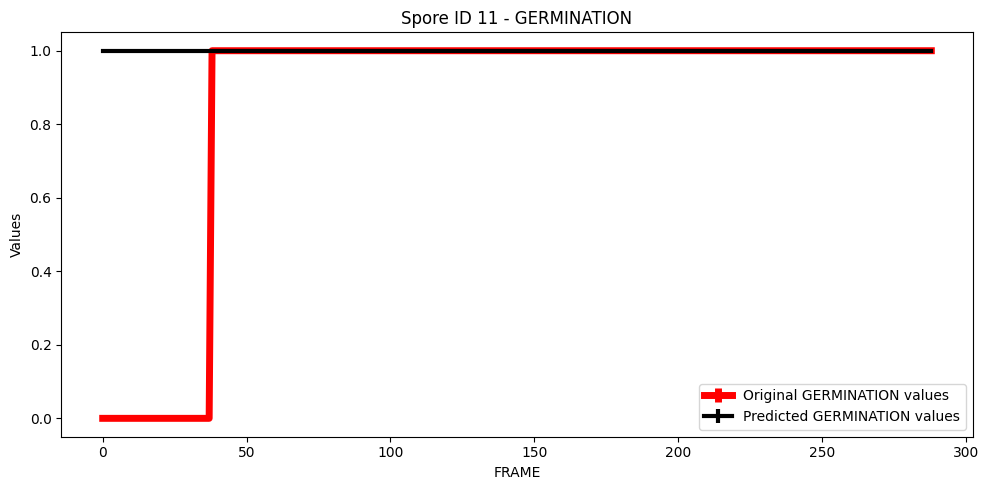

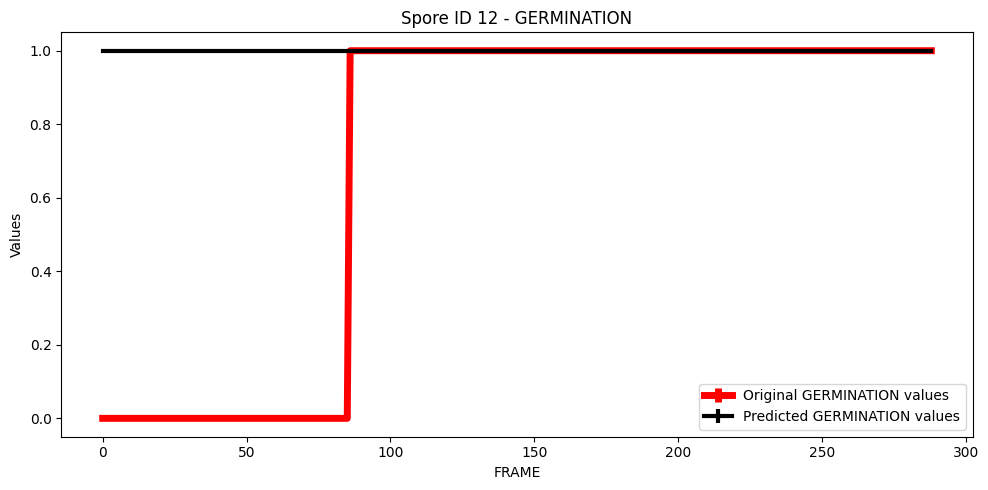

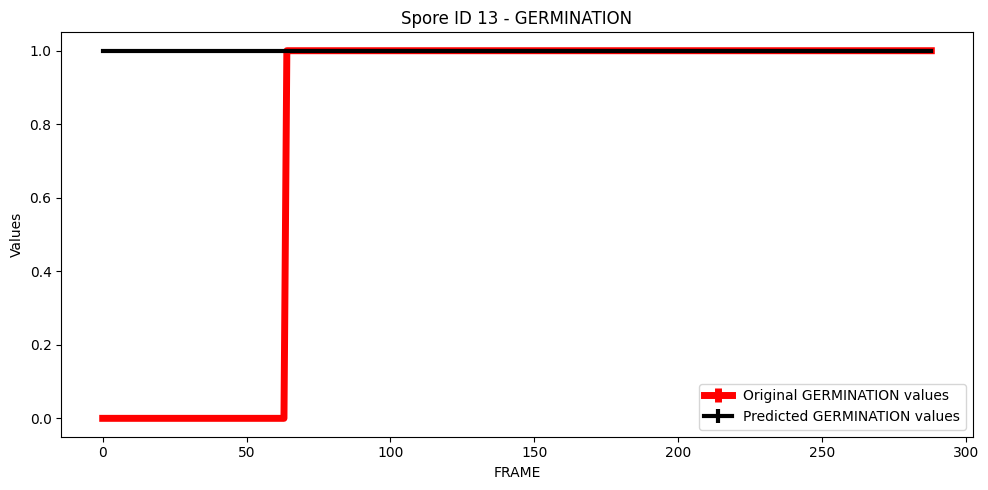

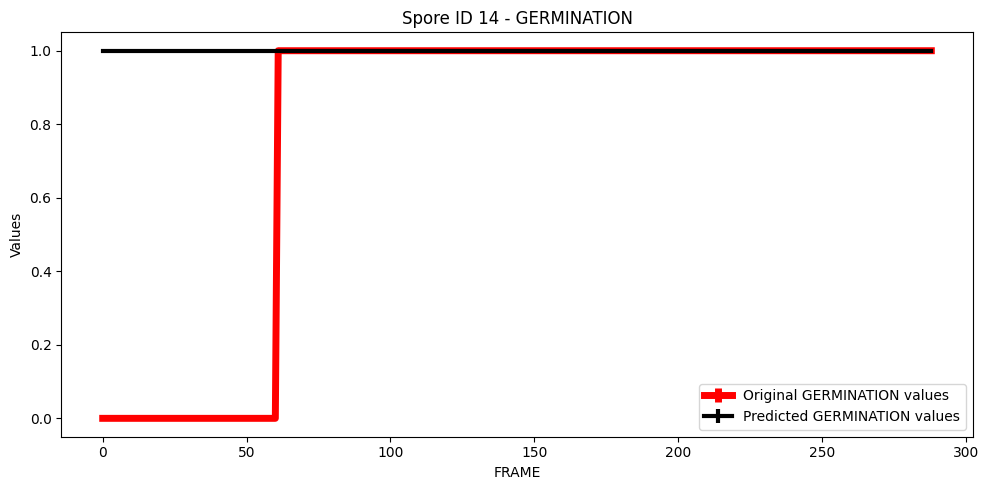

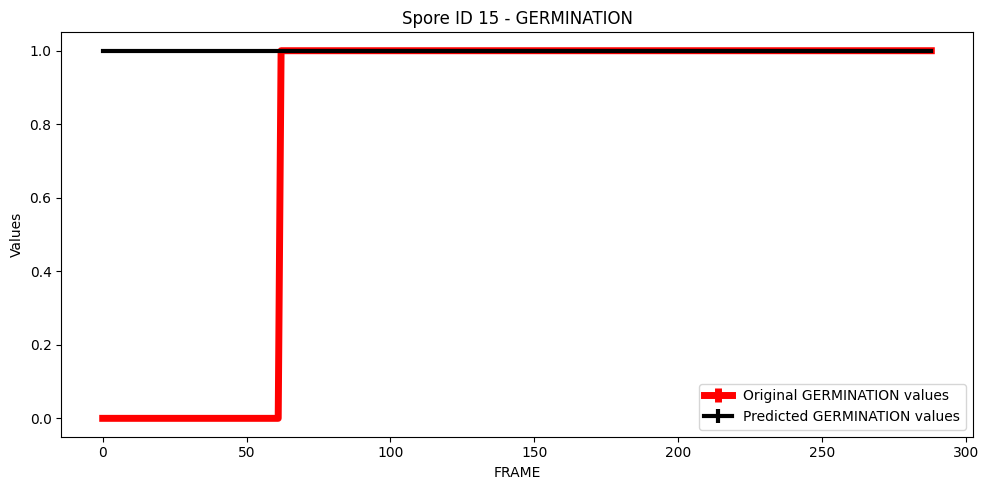

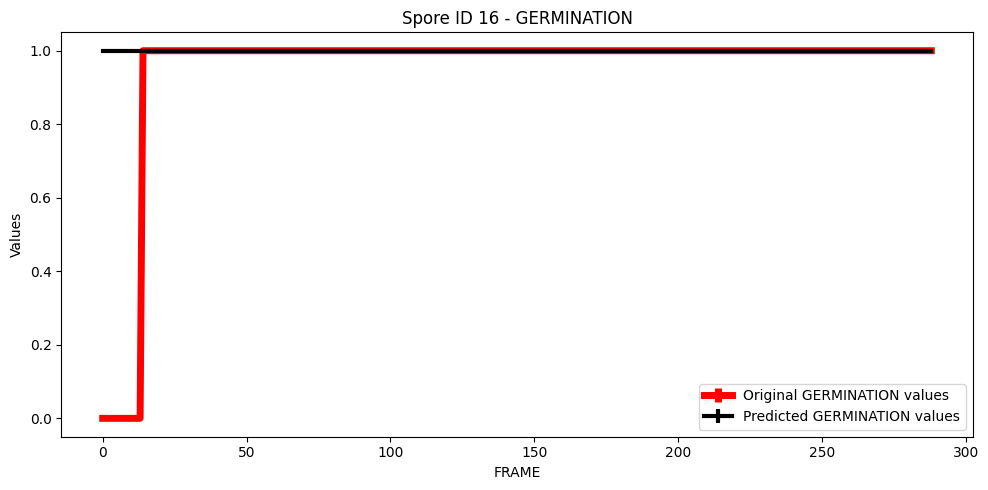

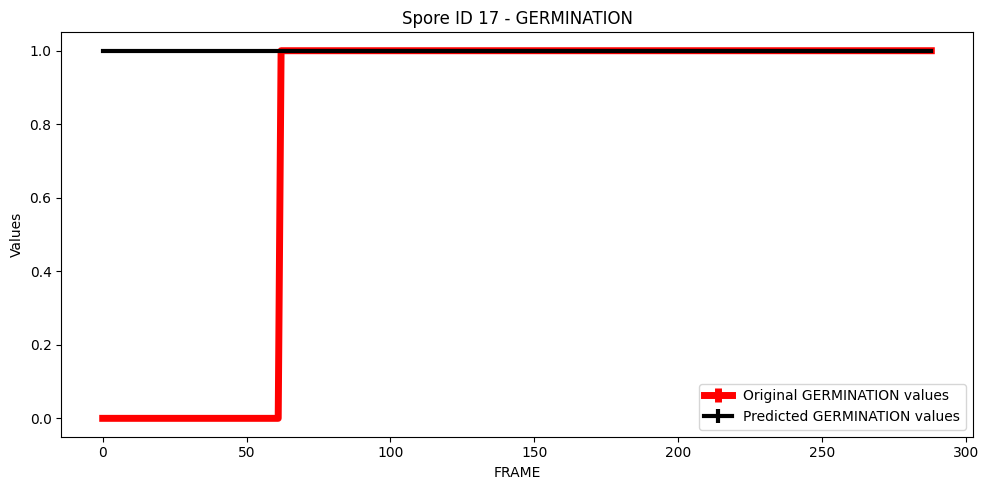

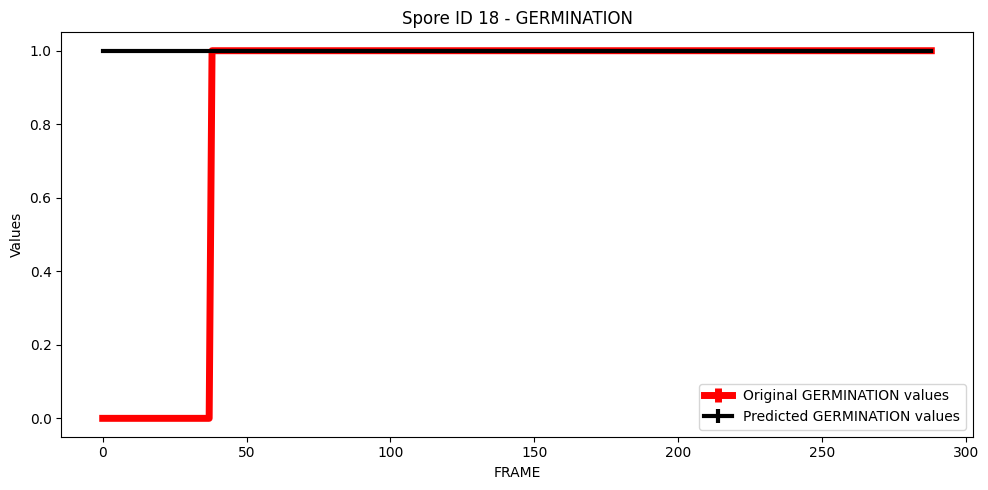

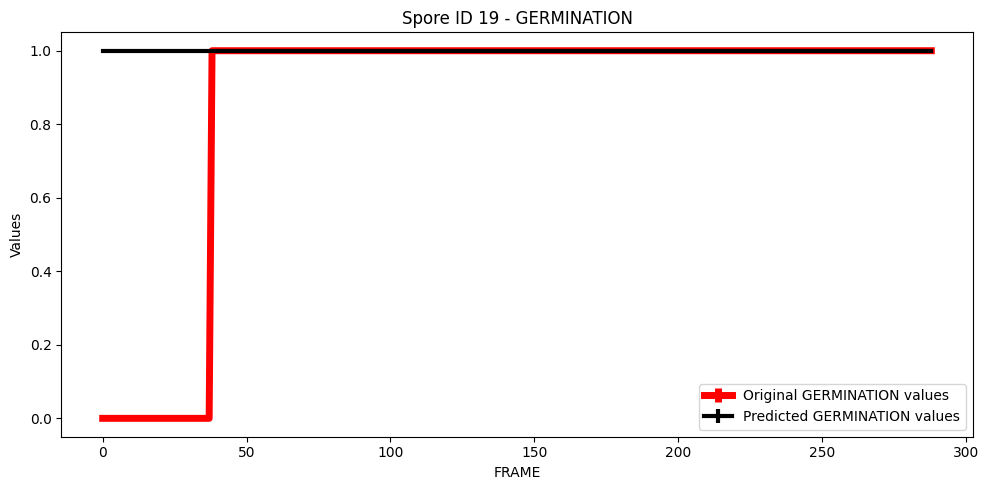

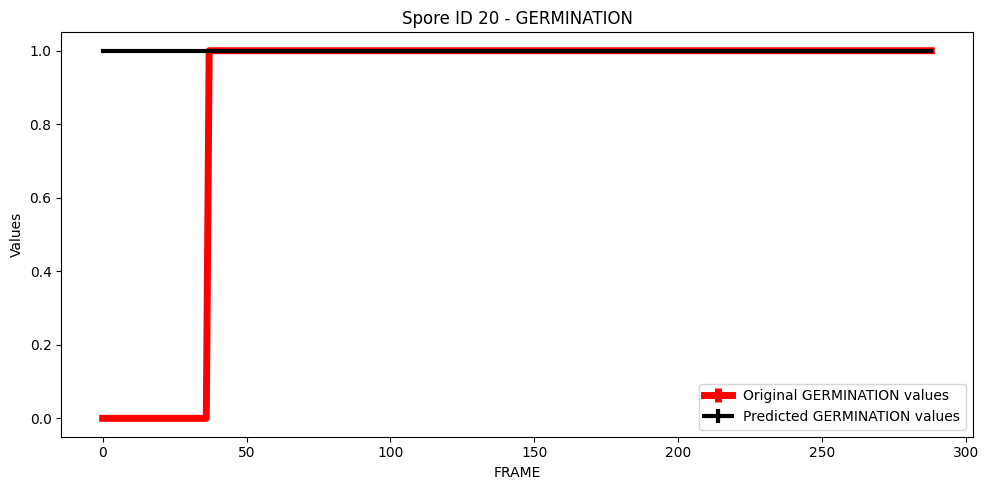

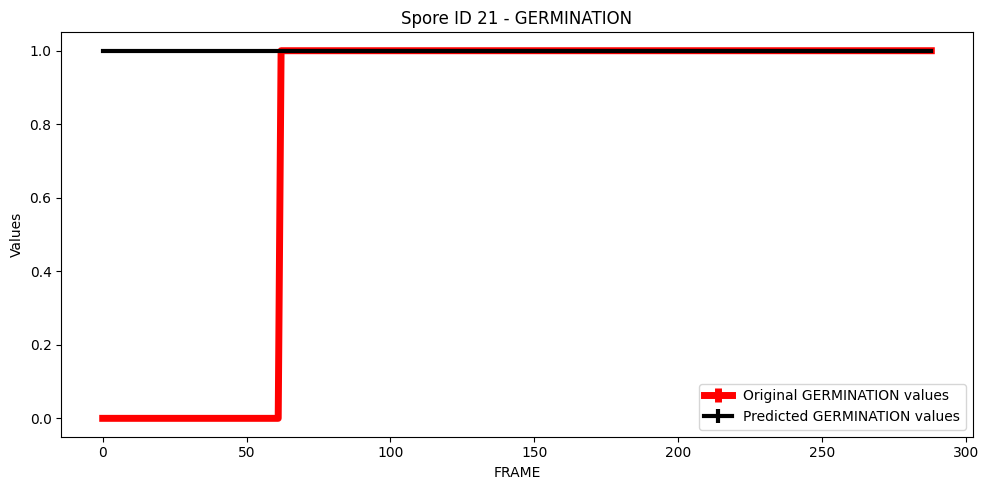

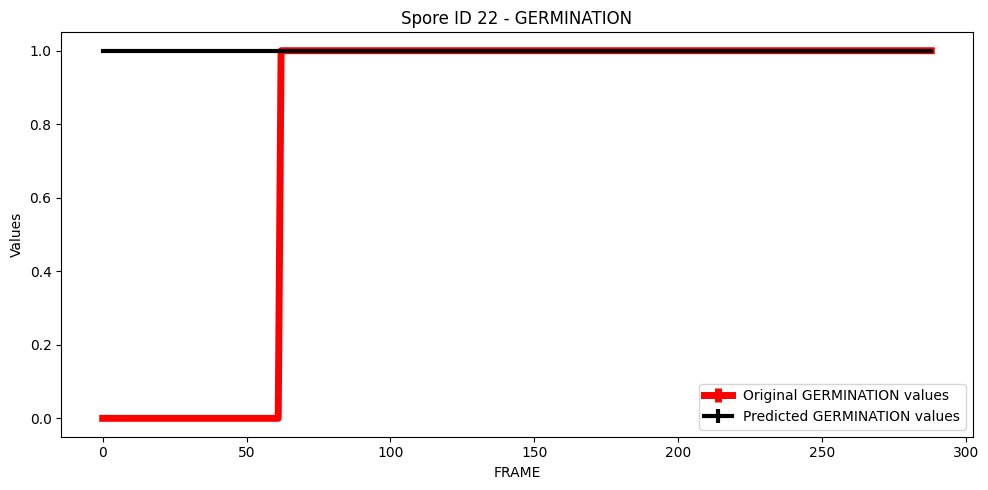

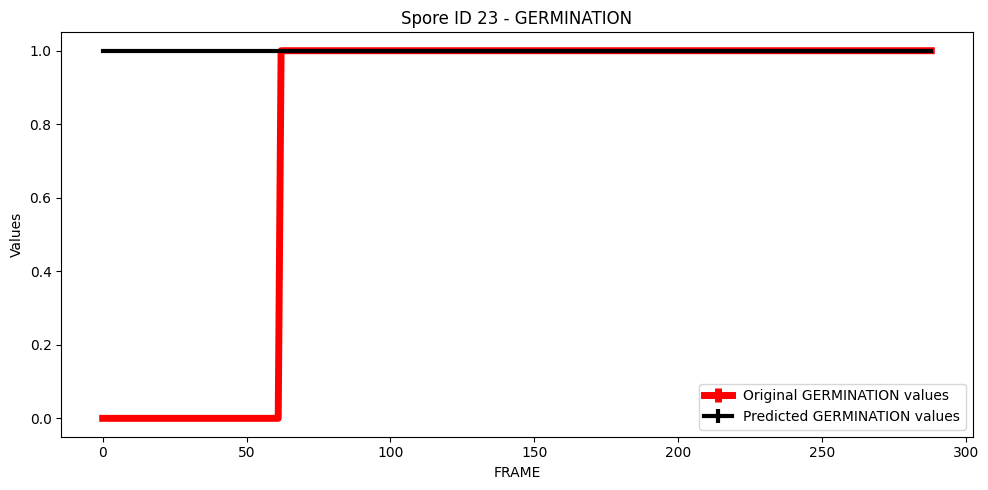

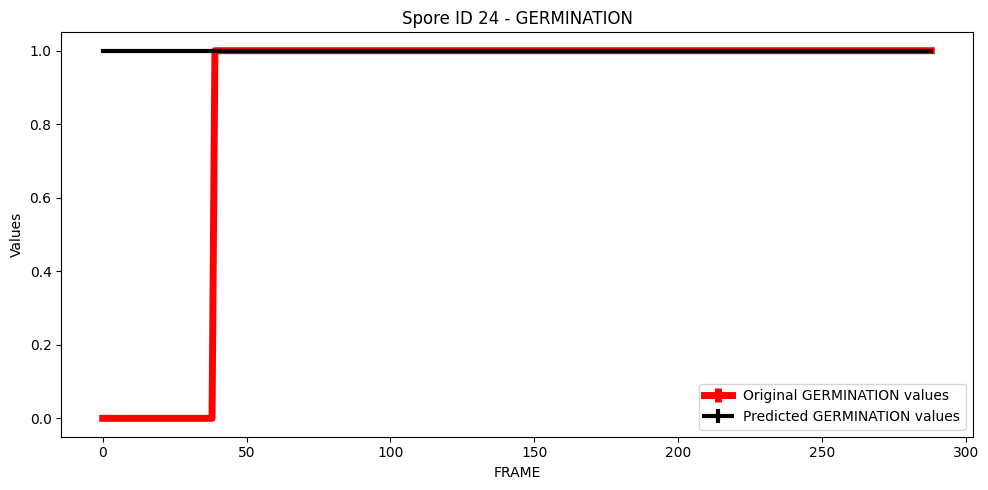

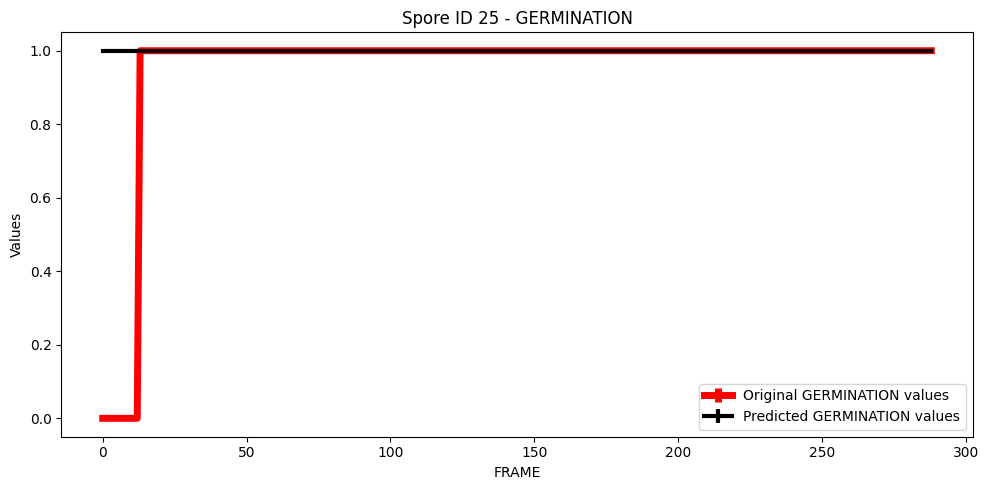

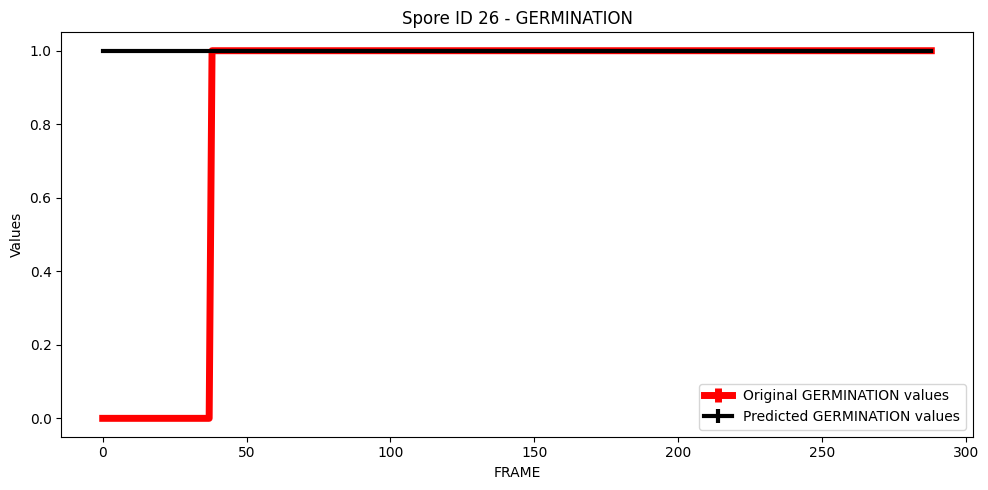

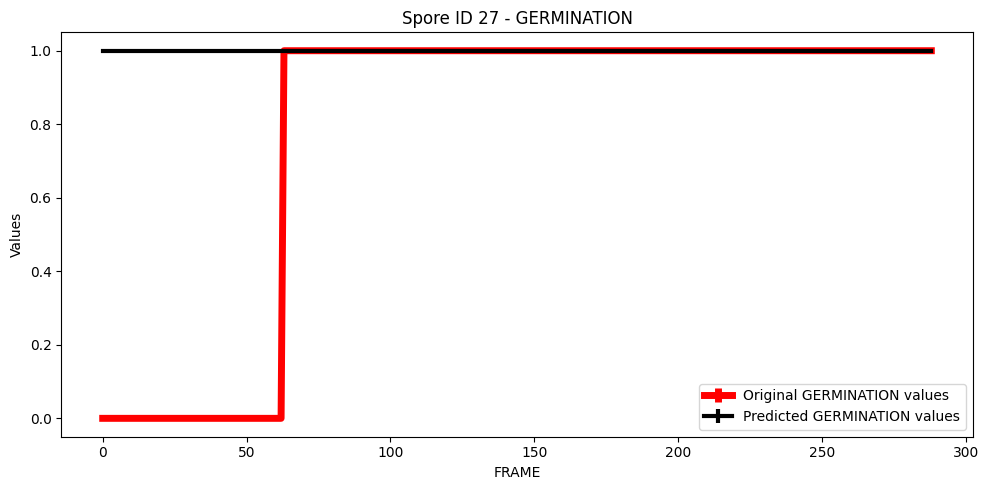

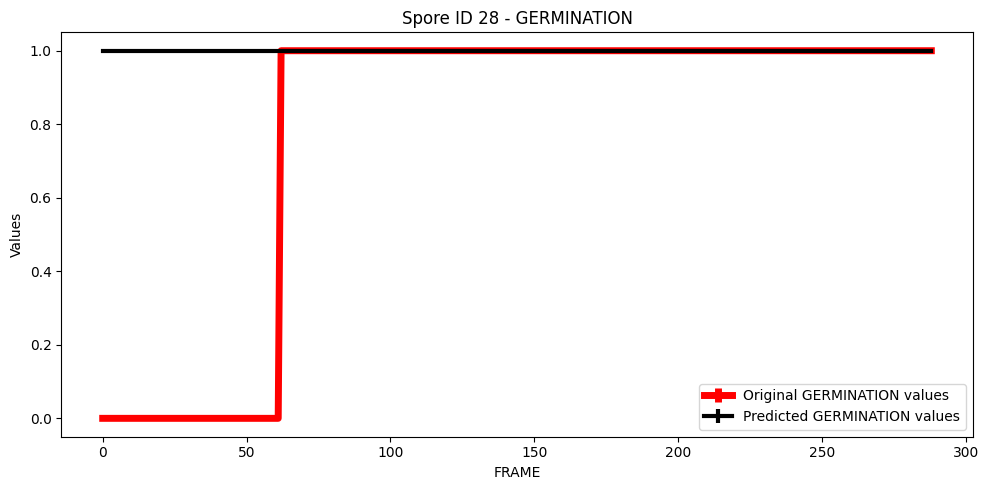

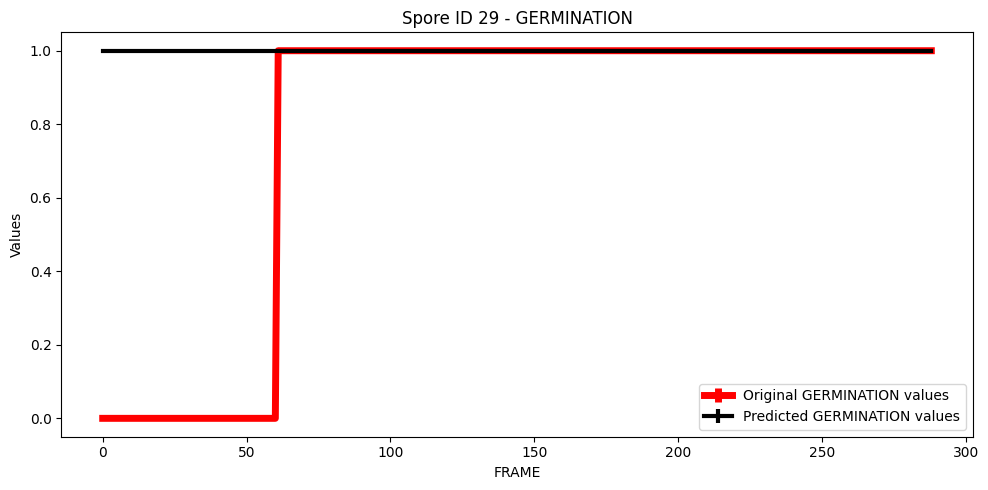

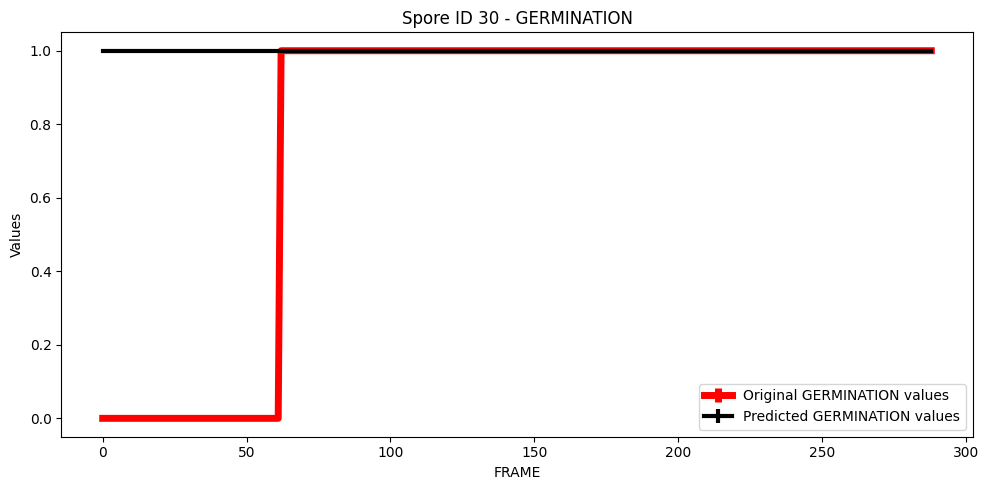

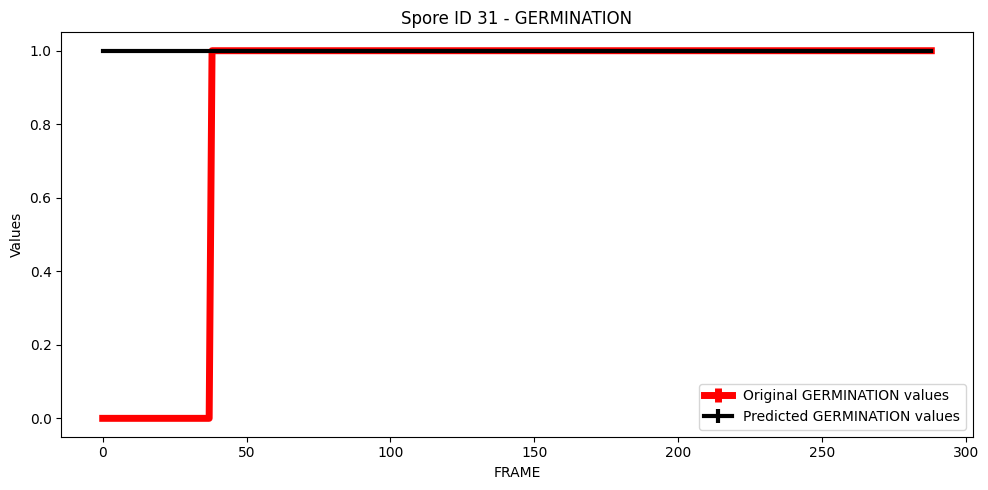

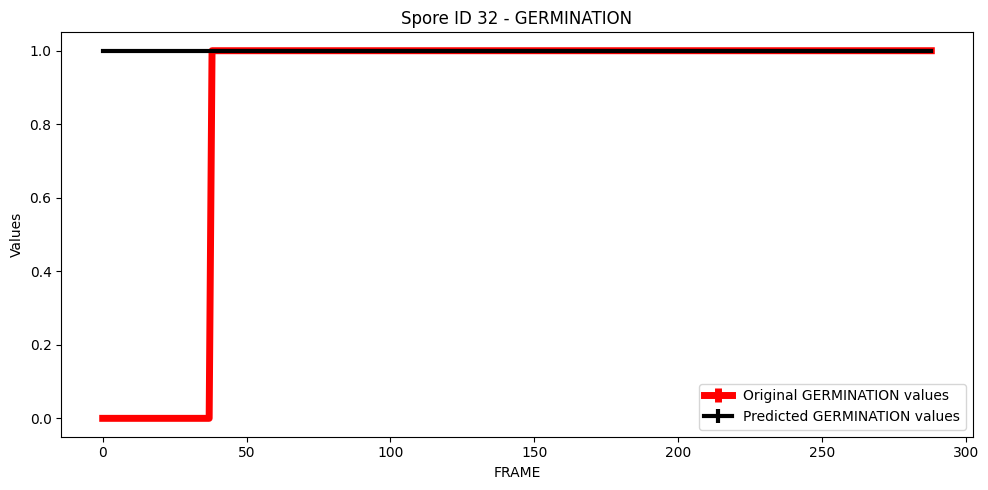

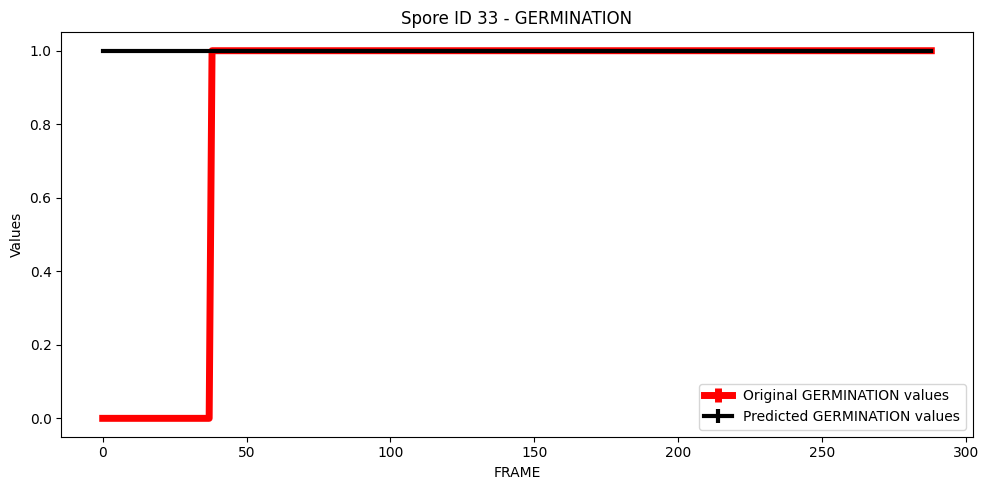

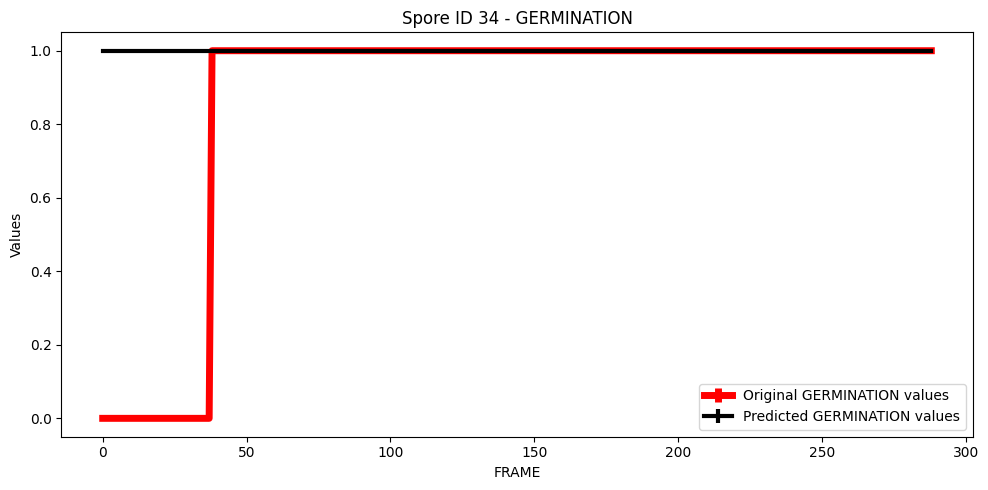

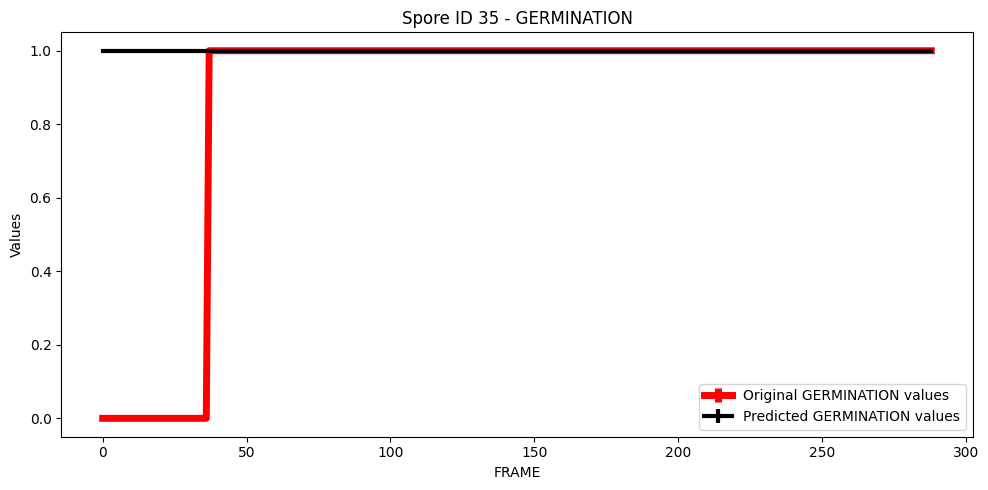

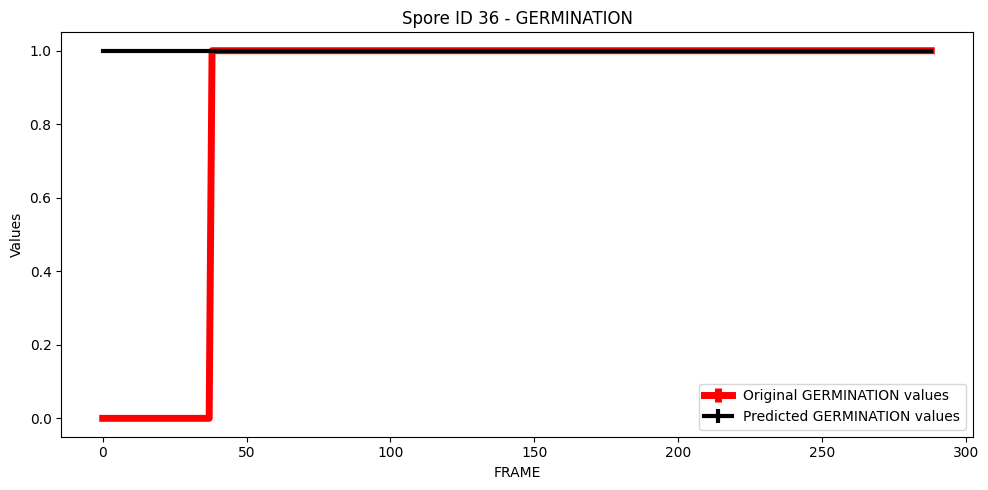

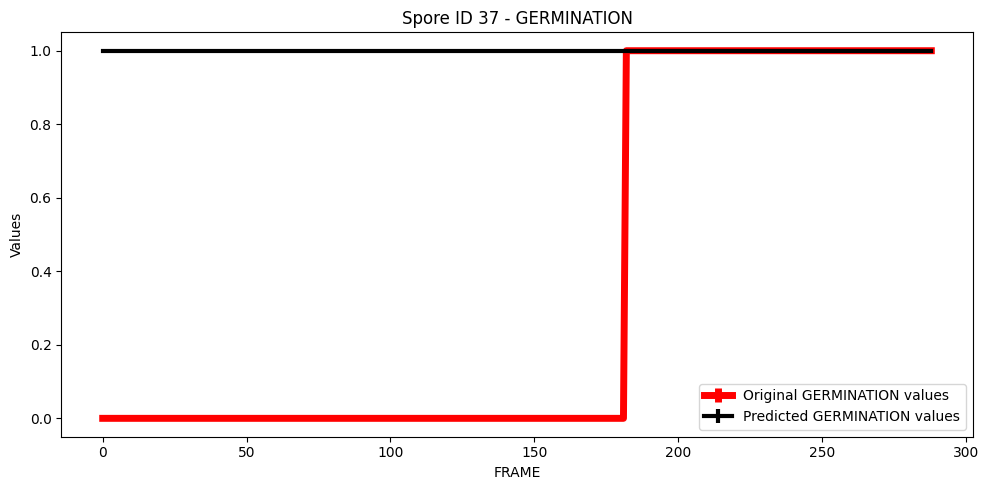

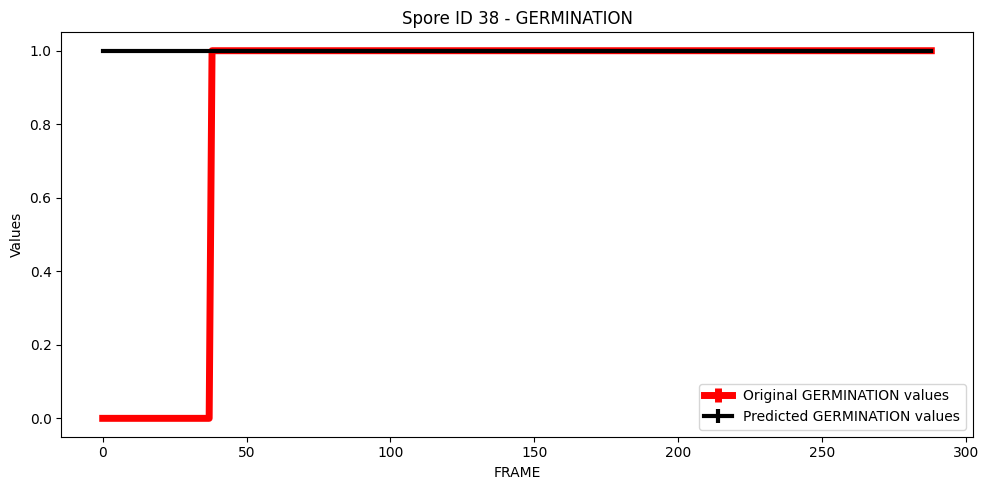

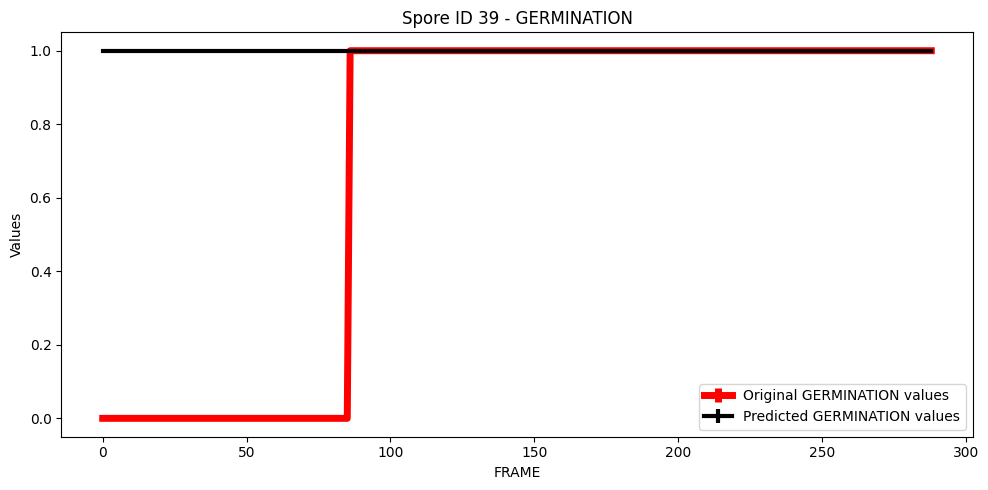

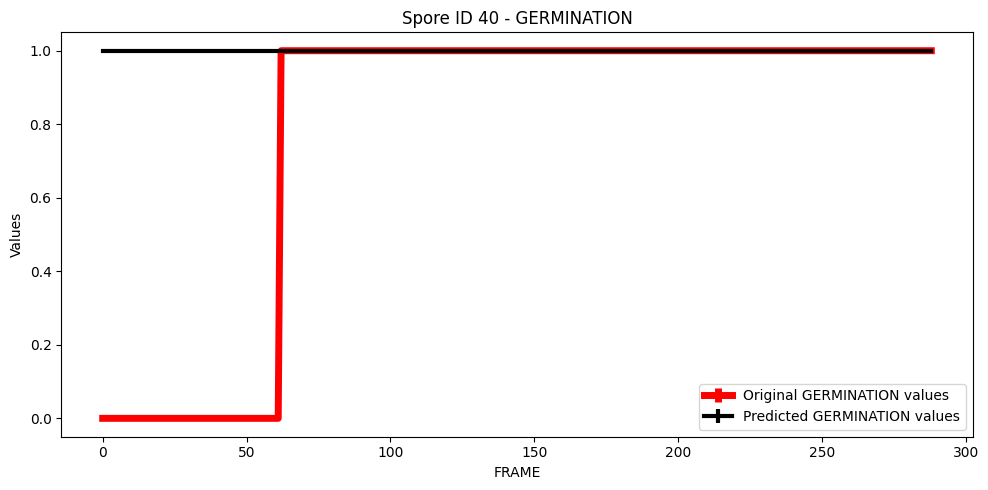

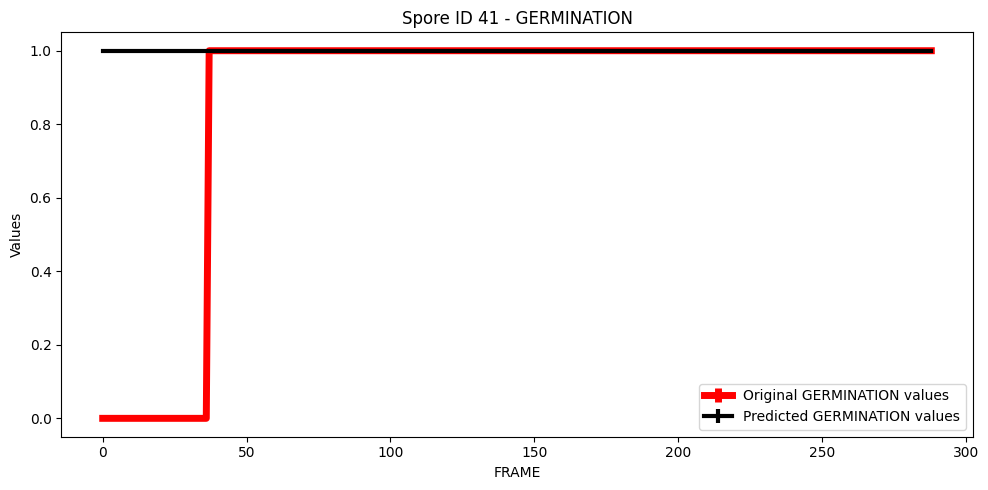

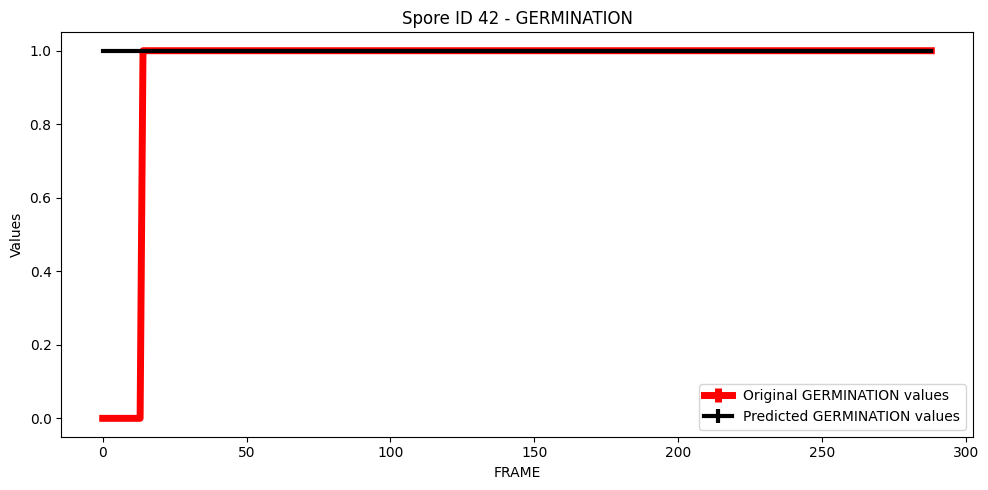

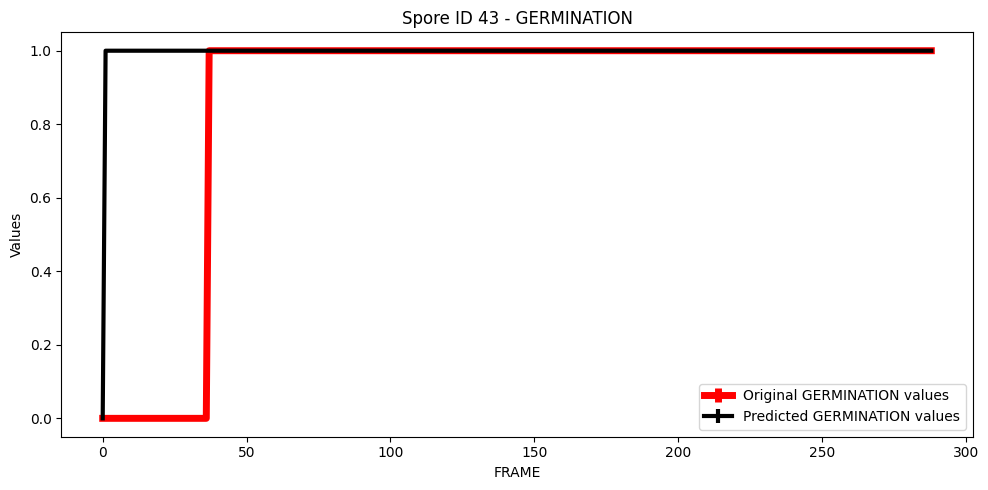

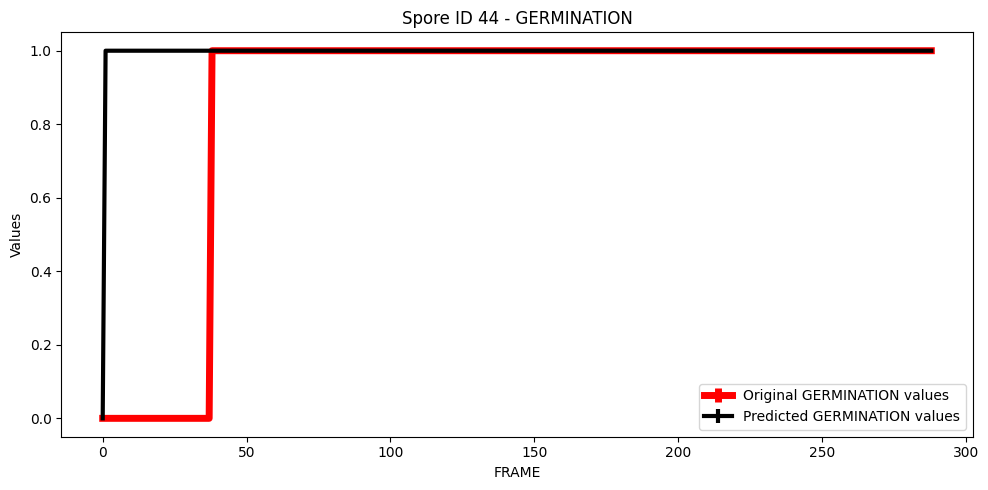

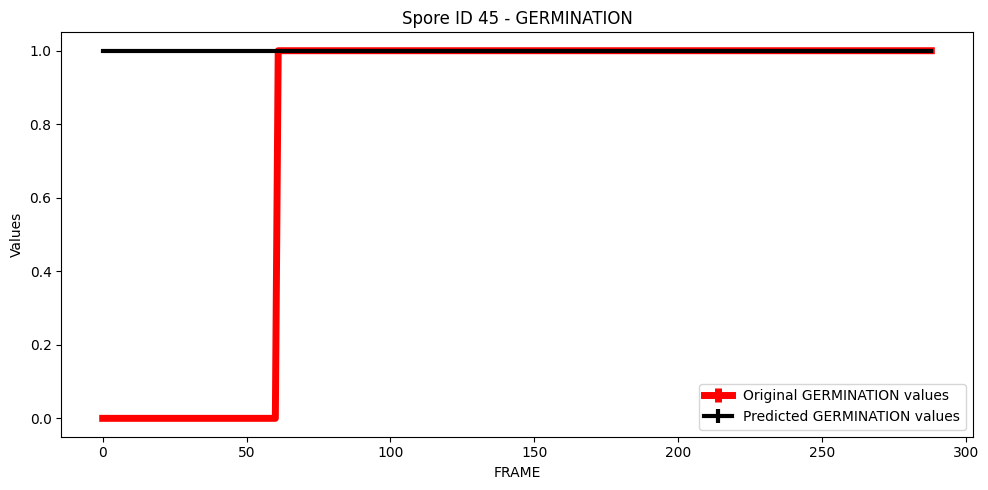

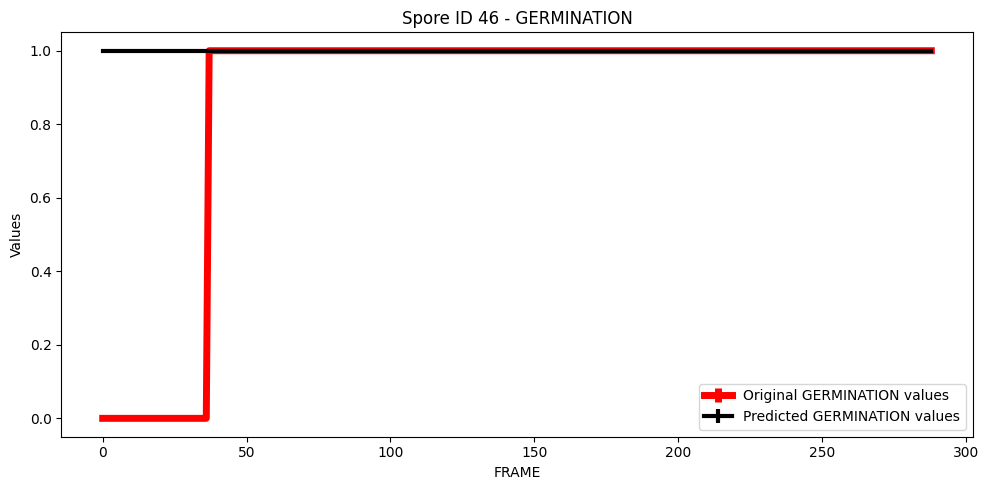

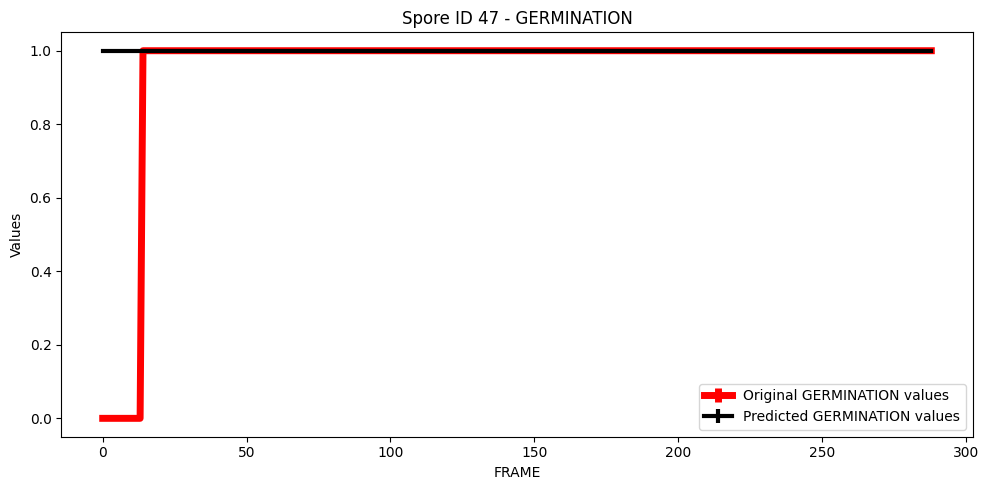

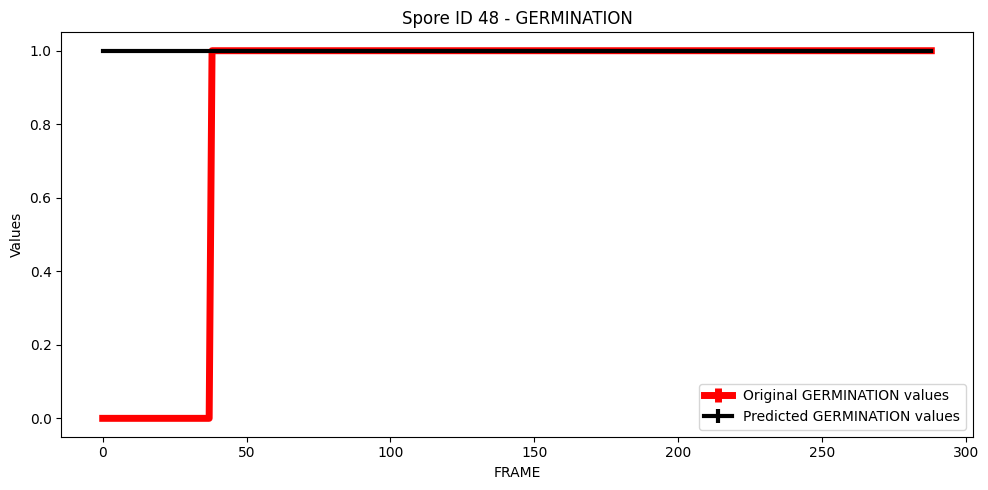

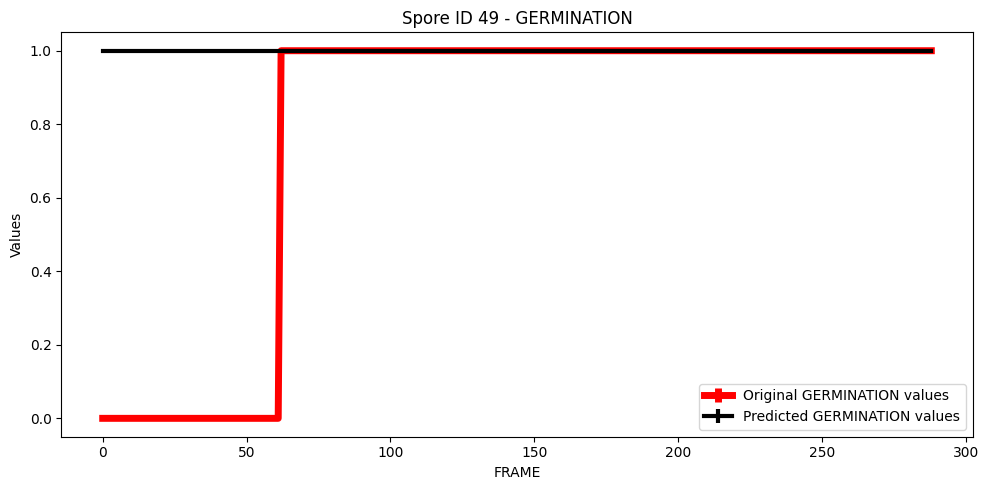

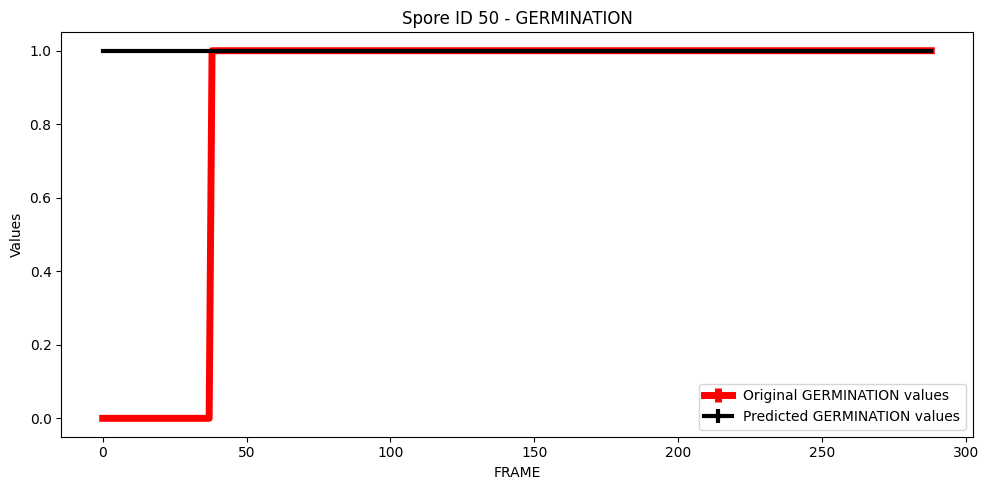

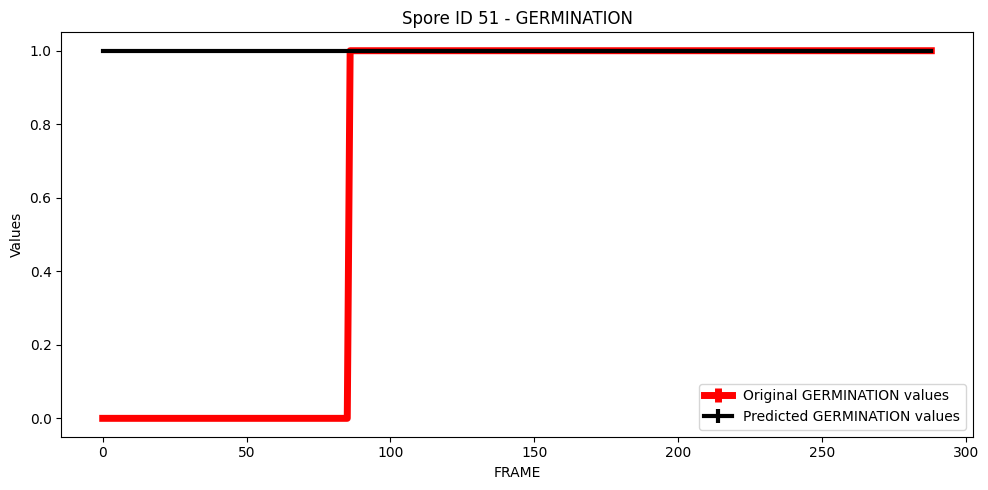

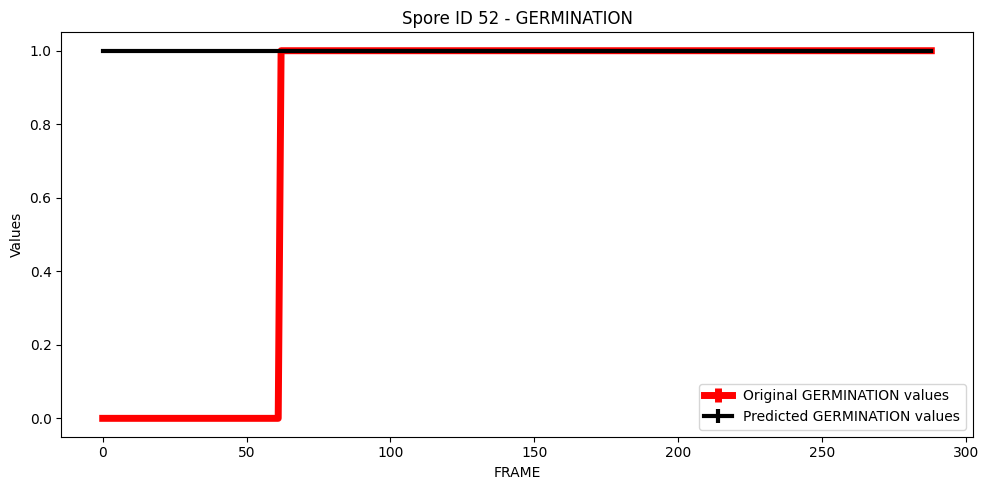

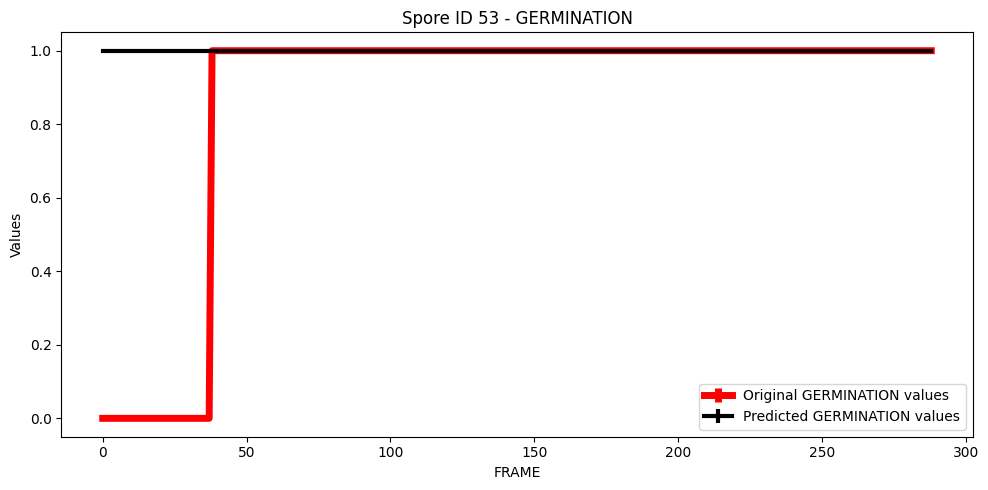

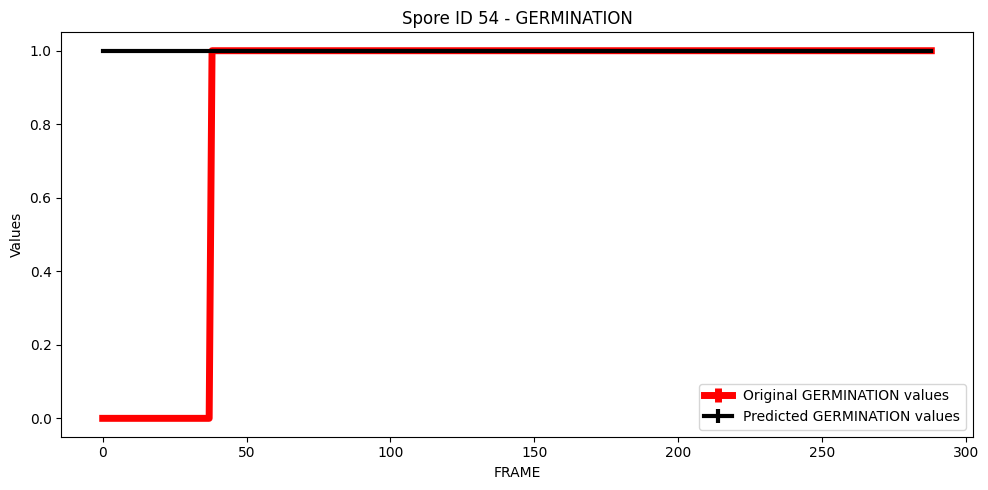

0.0% of spores predicted correctly...
54 spore incorrectly predicted...


In [229]:
# Get unique spore IDs
unique_spore_ids = df_test['new_spore_id'].unique()

# list of correct spores
spore_error: list[0, 1] = []

# Loop through each spore ID and create separate plots
for spore_id in unique_spore_ids:
    spore_data = df_test[df_test['new_spore_id'] == spore_id]
    
    # Create a new figure for each spore ID
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot GERMINATION values
    ax.errorbar(
        spore_data['FRAME'].unique(),
        spore_data.groupby(['FRAME']).mean()['GERMINATION'],
        yerr=spore_data.groupby(['FRAME']).sem()['GERMINATION'],
        color='red',
        linewidth = 5,
        label='Original GERMINATION values'
    )
    
    # Plot pred_germ1 values
    ax.errorbar(
        spore_data['FRAME'].unique(),
        spore_data.groupby(['FRAME']).mean()['pred_germ1'],
        yerr=spore_data.groupby(['FRAME']).sem()['pred_germ1'],
        color='black',
        linewidth = 3,
        label='Predicted GERMINATION values'
    )

    # Set plot title and labels
    ax.set_title(f'Spore ID {spore_id} - GERMINATION')
    ax.set_xlabel('FRAME')
    ax.set_ylabel('Values')
    ax.legend()

    #add 1 for correct and 0 for wrong
    binary_error = int((spore_data['GERMINATION'].mean() == spore_data['pred_germ1'].mean()))
    spore_error.append(binary_error)
    

    # Adjust layout
    plt.tight_layout()
    plt.show()

correct_percentage = (sum(spore_error) / len(spore_error)) * 100
print(f"{correct_percentage}% of spores predicted correctly...")
number_wrong = spore_error.count(0)
print(f"{number_wrong} spore incorrectly predicted...")